In [196]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from tsfresh.feature_extraction import extract_features
from tsfresh import select_features
from datetime import timedelta
from tsfresh.utilities.dataframe_functions import impute
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
import matplotlib.pyplot as plt


In [197]:
# database simulation
label = pd.read_pickle('label.pkl')
# features should also be somewhere in server! 
# (online feature extraction is too time consuming -> every training length need 10+ sec)
# this file is about 30M, should be ok
features = pd.read_pickle('2021_features.pkl')


In [198]:
# user interface
prediction_date = '2021-04-01 01:00:00'
prediction_length = 24

In [199]:
# get the training data
def GetData(label, features, prediction_date, prediction_length):
    training_length = 24*7*4*2 # 2 months

    # get train and test spot price
    label_index = label.index.get_loc(prediction_date)
    train_label = pd.Series(label.iloc[label_index+1-training_length:label_index+1].value)
    test_label = pd.Series(label.iloc[label_index:label_index+prediction_length].value)

    # get train and test features
    feature_index = features.index.get_loc(prediction_date)
    train_features = features.iloc[feature_index+1-training_length:feature_index+1]
    test_features = features.iloc[feature_index:feature_index+prediction_length]

    # missing value processing (just use the simple one, because we do not know where is the missin value and AR is time consuming)
    train_label = train_label.fillna(method='bfill')

    # error processing (prediction_date should be earlier than '2021-08-01 23:00:00' -> please set in web front)

    # dealing with future spot price (label.index[0]+timedelta(hours=3))
    # dealing with future features (use AR to predict features)

    return train_label, test_label, train_features, test_features

In [200]:
# get the training data
train_label, test_label, train_features, test_features = GetData(label, features, prediction_date, prediction_length)

In [201]:
def FeatureSelection(features, label, alpha=2):
    # 1.layer
    impute(features);
    features_filtered = select_features(features, label)
    # 2.layer
    model = linear_model.Lasso(alpha=alpha)
    # standardization
    X = StandardScaler().fit_transform(np.array(features_filtered))
    y = np.array(label)
    model.fit(X, y)
    feature_coeff = pd.Series(model.coef_, index=features_filtered.columns)
    feature_coeff = feature_coeff.sort_values(ascending=False)
    feature_names = feature_coeff[feature_coeff.abs()>0].index
    selected_features = feature_coeff[feature_coeff.abs()>0]
    return feature_names, selected_features

In [202]:
feature_names, _ = FeatureSelection(train_features, train_label, alpha=2)
train_X = StandardScaler().fit_transform(np.array(train_features[feature_names]))
test_X = StandardScaler().fit_transform(np.array(test_features[feature_names]))

In [203]:
# ARIMA with online parameter searching
def ARIMA_online_search(train_label, test_label, train_X, test_X):
    model = auto_arima(train_label, max_p=8, max_q=8, max_order=None, \
                seasonal=False, \
                exogenous=train_X, \
                trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)
    pred_label, conf_int = model.predict(n_periods=test_label.shape[0], X=test_X, return_conf_int=True)
    low_bound = conf_int[:, 0]
    up_bound = conf_int[:, 1]
    return pred_label, low_bound, up_bound

# ARIMA with fixed parameters
def ARIMA_fixed(train_label, test_label, train_X, test_X):
    model =  pm.ARIMA(order=(2,1,3))
    model.fit(train_label, train_X)
    pred_label, conf_int = model.predict(n_periods=test_label.shape[0], X=test_X, return_conf_int=True)
    low_bound = conf_int[:, 0]
    up_bound = conf_int[:, 1]
    return pred_label, low_bound, up_bound

# visualization
def PlotResult(train_label, test_label, pred_label, low_bound, up_bound):
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    train_label[-len(test_label)*4:].plot(ax=ax)
    test_label.plot(ax=ax)
    pred_label = pd.DataFrame({'date': test_label.index, 'value': pred_label}).set_index('date')
    pred_label.plot(ax=ax)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8264.042, Time=6.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14305.315, Time=2.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=4.34 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=4.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8282.772, Time=5.71 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8242.219, Time=5.88 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8260.832, Time=3.94 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=4.26 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8221.798, Time=7.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=6.83 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8218.437, Time=6.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=7.11 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=8202.591, Time=6.86 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=6.53 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=8214.528, Time=8.01 

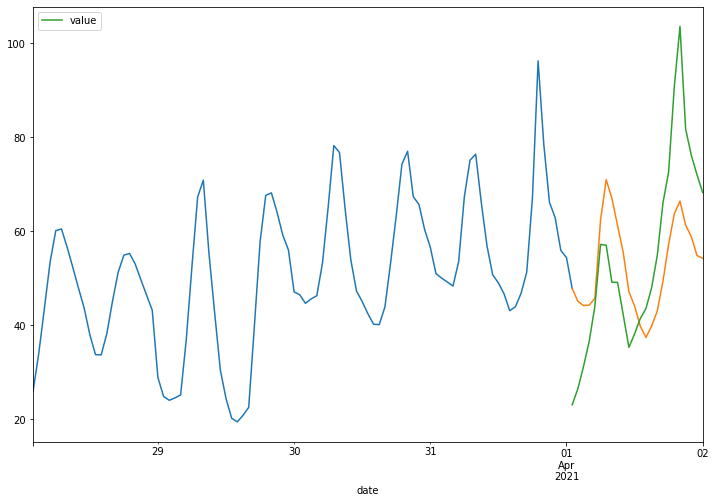

In [204]:
pred_label, low_bound, up_bound = ARIMA_online_search(train_label, test_label, train_X, test_X)
PlotResult(train_label, test_label, pred_label, low_bound, up_bound)

In [205]:
pred_label

array([ 23.05825901,  26.44040214,  31.20015267,  36.55069359,
        43.99444819,  57.17953352,  57.02359924,  49.13940186,
        49.11438872,  42.19404041,  35.27287363,  38.13863347,
        41.3842571 ,  43.53850777,  47.95164803,  54.84921875,
        66.01419462,  72.63431207,  90.74840503, 103.56377713,
        81.72597143,  76.15416394,  72.02590335,  68.23147047])

In [206]:
test_label

date
2021-04-01 01:00:00    47.82
2021-04-01 02:00:00    45.10
2021-04-01 03:00:00    44.17
2021-04-01 04:00:00    44.27
2021-04-01 05:00:00    45.70
2021-04-01 06:00:00    62.36
2021-04-01 07:00:00    70.97
2021-04-01 08:00:00    67.00
2021-04-01 09:00:00    61.22
2021-04-01 10:00:00    55.45
2021-04-01 11:00:00    47.14
2021-04-01 12:00:00    44.08
2021-04-01 13:00:00    39.82
2021-04-01 14:00:00    37.37
2021-04-01 15:00:00    39.81
2021-04-01 16:00:00    43.01
2021-04-01 17:00:00    49.35
2021-04-01 18:00:00    57.19
2021-04-01 19:00:00    63.70
2021-04-01 20:00:00    66.41
2021-04-01 21:00:00    61.28
2021-04-01 22:00:00    58.83
2021-04-01 23:00:00    54.82
2021-04-02 00:00:00    54.24
Name: value, dtype: float64